In [1]:
# Import Google Drive and mount
from google.colab import drive
drive.mount('/content/gdrive')

# Unzip dataset
!unzip "/content/gdrive/My Drive/Colab Notebooks/Deep Learning - MSc AI/Assignment 2/data1-2.h5.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/Colab Notebooks/Deep Learning - MSc AI/Assignment 2/data1-2.h5.zip
  inflating: data1.h5                


# Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sys
import tensorflow as tf
import time

from tensorflow.python.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                            Dense, Dropout, Average)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


# Ignore TensorFlow warnings
tf.logging.set_verbosity(tf.logging.ERROR)
# Reset TensorFlow default graph
tf.reset_default_graph()

# Build CNN Class

In [0]:
class ShallowCNN:

    @staticmethod
    def load_data_h5(path_to_file):
        """
        Load test and validation data from .h5 file.

        :param path_to_file: (str) The path to file
        :return: x_train: (ndarray) The training data feature set
        :return: y_train: (ndarray) The training data class labels
        :return: x_val: (ndarray) The validation data feature set
        :return: y_val: (ndarray) The validation data class labels
        :raises: exception (catch-all) When error found loading data
        """
        try:
            with h5py.File(path_to_file, 'r') as hf:
                x_train = np.array(hf.get('trainX'))
                y_train = np.array(hf.get('trainY'))
                x_val = np.array(hf.get('valX'))
                y_val = np.array(hf.get('valY'))
            return x_train, y_train, x_val, y_val
        except Exception as e:
            print("There was an issue extracting the data...")
            sys.exit(e)

    @staticmethod
    def plot_charts(history, epochs, chart_title):
        """
        Given a Keras history object, output the associated training and
        validation accuracy and loss results in a line chart.

        :param history: (keras-history-obj) The model history object
        :param epochs: (int) The amount of epochs used in training process
        :param chart_title: (string) The chart title
        """
        h = history
        e = epochs
        plt.style.use('ggplot')
        plt.figure()
        plt.plot(np.arange(0, e), h.history['loss'], label="train_loss")
        plt.plot(np.arange(0, e), h.history['val_loss'], label="val_loss")
        plt.plot(np.arange(0, e), h.history['acc'], label="train_acc")
        plt.plot(np.arange(0, e), h.history['val_acc'], label="val_acc")
        plt.title(chart_title)
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()

    @staticmethod
    def build_cnn(height, width, depth, classes, conv_cnt, conv_layers,
                  filters, k_size, fc=False, fc_layers=None,
                  neuron_cnt=None, dropout_rate=0.):
        """
        Build the convolutional neural network.

        :param height: (int) The image height dimension
        :param width: (int) The image width dimension
        :param depth: (int) The depth of the image (channel count)
        :param classes: (int) The amount of target classes in the dataset
        :param conv_cnt: (int) The amount of convolutions in the model
        :param conv_layers: (int) The amount of layers in each convolution
        :param filters: (list) The filter count for each layer, the size of the
        list must equal the conv_cnt value
        :param k_size: (tuple) The kernel size
        :param fc: (bool) If the model should include fully connected (FC)
        layers of ReLu neurons
        :param fc_layers: (int) The amount of FC layers to include
        :param neuron_cnt: (list) The amount of neurons in each FC layer, the
        size of the list must equal the fc_layer value
        :param dropout_rate: (float) The dropout rate to implement in the FC
        layers, default is 0.0 (no dropout)
        :return: (keras-model) The model with all layers defined
        """
        # Instantiate a sequential keras model
        model = Sequential()
        # Set the input shape tuple
        i_shape = (height, width, depth)

        # For each convolution...
        for con in range(0, conv_cnt):
            # For each layer
            for i in range(0, conv_layers):
                # Add 2D convolutional layers equal to conv_layer value
                model.add(Conv2D(filters[con], k_size, padding='same',
                                 input_shape=i_shape, activation='relu'))
            # Add a 2D MaxPooling layer with pool size 2x2
            model.add(MaxPooling2D(pool_size=(2, 2)))

        # Flatten the network
        model.add(Flatten())
        # If FC (fully connected) layers are enabled
        if fc:
            # For each FC layer...
            for fc_layer in range(0, fc_layers):
                # Add fully connected layer of ReLu neurons, neuron count is
                # equal to value specified in neuron_cnt
                model.add(Dense(neuron_cnt[fc_layer], activation='relu'))
                # If dropout regularisation is enabled...
                if dropout_rate:
                    # Set the dropout rate to apply to previous FC layer
                    model.add(Dropout(dropout_rate))

        # Add the softmax classifier with value of classes set
        model.add(Dense(classes, activation='softmax'))

        # Return the built network architecture
        return model

    def run_compile_fit_evaluate(
            self, model, x_train, y_train, x_val, y_val, n_epochs=10,
            batch_size=0, augmented=False, aug_generator=None,
            plot_chart=True, chart_title='Part A', return_model=False):
        """
        Given a Keras sequential model with layers defined, compile, fit, and
        evaluate that model, outputting test loss, accuracy, and charts when
        done.

        :param model: (keras-model) The sequential Keras model
        :param x_train: (ndarray) The training data feature set
        :param y_train: (ndarray) The training data class labels
        :param x_val: (ndarray) The validation data feature set
        :param y_val: (ndarray) The validation data class labels
        :param n_epochs: (int) The number of epochs to run, default 10
        :param batch_size: (int) The batch size, default 0 full data set
        :param augmented: (bool) If the model will use of augmented test data
        :param aug_generator: (generator) The augmented data generator
        :param plot_chart: (bool) If a chart is to be output, only works when
        epochs are implemented in model.
        :param chart_title: (string) The chart title specific to model
        :param return_model: (bool) If the model should be returned
        :return: (keras-model) The trained
        """
        # Set model optimiser
        optimizer = SGD(lr=0.01)
        # Set model loss function
        loss = "sparse_categorical_crossentropy"
        # Configure the model for training
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        # Start model training timer
        s_time = time.time()
        # If data augmentation is enabled...
        if augmented:
            # Train the model on data generated batch-by-batch by generator
            history = model.fit_generator(
                aug_generator, validation_data=(x_val, y_val),
                steps_per_epoch=(len(train_x) / batch_size), epochs=n_epochs)
        # Else data augmentation not enabled...
        else:
            # Train the model for a given number of epochs
            history = model.fit(x_train, y_train,
                                validation_data=(x_val, y_val),
                                batch_size=batch_size, epochs=n_epochs)
        print("Time taken to train model: {}s".format(time.time() - s_time))

        # If return model is enabled...
        if return_model:
            # Return model
            return model
        # Else evaluate model and output results...
        else:
            # Calculate the loss value & metrics values for the model
            results_prob = model.evaluate(x_val, y_val)
            print("Validation loss: {}\nValidation Accuracy: {}".format(
                results_prob[0], results_prob[1]))
            # If plot_chart is enabled, output loss and accuracy line chart
            if plot_chart:
                self.plot_charts(history, n_epochs, chart_title)

    @staticmethod
    def augment_training_data(train_images, train_labels, batch_size,
                              width_shift=0., height_shift=0., shear=0.,
                              zoom=0., rotation=0, h_flip=False, v_flip=False):
        """
        Generate batches of tensor image data with real-time data augmentation.
        The data will be looped over (in batches).

        :param train_images: (ndarray) The training data feature set
        :param train_labels: (ndarray) The training data class labels
        :param batch_size: (int) The batch size, default 0 full data set
        :param width_shift: (float) Degree at which to shift image width
        :param height_shift: (float) Degree at which to shift image height
        :param shear: (float) Degree at which to shear image
        :param zoom: (float) Degree at which to zoom image
        :param rotation: (float) Degree range for random rotations
        :param h_flip: (bool) Randomly flip image horizontally
        :param v_flip: (bool) Randomly flip image vertically
        :return: (generator) The batches of augmented image data
        """

        # Define real-time data augmentation parameters
        train_data_generator = ImageDataGenerator(
            width_shift_range=width_shift, height_shift_range=height_shift,
            shear_range=shear, zoom_range=zoom, rotation_range=rotation,
            horizontal_flip=h_flip, vertical_flip=v_flip)

        # Take data & label arrays, generate batches of augmented data
        train_generator = train_data_generator.flow(train_images, train_labels,
                                                    batch_size)

        return train_generator

    @staticmethod
    def ensemble_predict(models, x_val, y_val, batch_size=16):
        """
        Using the ensemble technique, take two or more models and perform
        predictions using validation data. Take all model predictions, average
        them and using argmax determine the target class over all models. Take
        the predictions and determine the accuracy by comparing with the
        validation labels and dividing the total correct predictions by the
        amount of images in the validation data set.

        :param models: (list) List of two or more trained neural networks
        :param x_val: (ndarray) The validation data feature set
        :param y_val: (ndarray) The validation data class labels
        :param batch_size: (int) The batch size, default 16
        :return:
        """
        # Create list to hold each models predictions
        model_predictions = list()
        # For each model provided...
        for model in models:
            # Predict the accuracy of the model, this is performed in batches
            model_predictions.append(model.predict(x_val,
                                                   batch_size=batch_size))

        # Take as input the list of tensors all of the same shape, and returns
        # a single tensor also of the same shape representing the average of
        # all input tensors
        pred_average = Average()(model_predictions)
        # Get the predicted target class as defined by the maximum value along
        # numpy array axis 1
        predictions = np.argmax(pred_average, axis=1)
        # Compare the predicted class with the validation labels to determine
        # amount of correct predictions, divide by the amount of validation
        # images to get the accuracy of the ensemble
        acc = np.sum(np.equal(predictions, y_val)) / y_val.shape[0]

        return acc

# Set Global Variables & Load Data

In [4]:
# Declare Network Constants
NUM_EPOCHS = 50
BATCH_SIZE = 16

# Instantiate CNN class and load data
cnn = ShallowCNN()
print("Loading Data...")
train_x, train_y, val_x, val_y = cnn.load_data_h5('data1.h5')
print("Data Loaded...")

Loading Data...
Data Loaded...


# Part 1 - Multi-Architecture CNNs


### Single Layer CNN with only a flatten layer before softmax classifier

Train on 1020 samples, validate on 340 samples
Epoch 1/50
1020/1020 [==============================] - 4s 4ms/sample - loss: 2.5351 - acc: 0.1853 - val_loss: 2.0142 - val_acc: 0.3559
Epoch 2/50
1020/1020 [==============================] - 1s 776us/sample - loss: 1.8931 - acc: 0.3824 - val_loss: 1.8262 - val_acc: 0.3529
Epoch 3/50
1020/1020 [==============================] - 1s 800us/sample - loss: 1.5393 - acc: 0.5157 - val_loss: 1.7260 - val_acc: 0.4294
Epoch 4/50
1020/1020 [==============================] - 1s 786us/sample - loss: 1.2971 - acc: 0.5931 - val_loss: 1.7336 - val_acc: 0.3941
Epoch 5/50
1020/1020 [==============================] - 1s 776us/sample - loss: 1.1028 - acc: 0.6765 - val_loss: 1.4962 - val_acc: 0.5059
Epoch 6/50
1020/1020 [==============================] - 1s 774us/sample - loss: 0.9307 - acc: 0.7088 - val_loss: 1.6641 - val_acc: 0.4676
Epoch 7/50
1020/1020 [==============================] - 1s 771us/sample - loss: 0.7830 - acc: 0.7667 - val_loss: 1.3946 - val_a

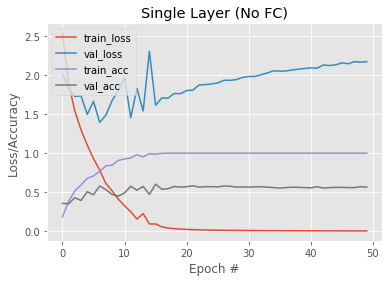

In [5]:
title = 'Single Layer (No FC)'
sp_model = cnn.build_cnn(
    height=128, width=128, depth=3, classes=17, conv_cnt=1, conv_layers=1,
    filters=[32], k_size=(3, 3))

cnn.run_compile_fit_evaluate(
    sp_model, train_x, train_y, val_x, val_y, n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, plot_chart=True, chart_title=title)

 ### Single Layer CNN with fully-connected (FC) layer
 

Train on 1020 samples, validate on 340 samples
Epoch 1/50
1020/1020 [==============================] - 1s 1ms/sample - loss: 2.6127 - acc: 0.1471 - val_loss: 2.2524 - val_acc: 0.2353
Epoch 2/50
1020/1020 [==============================] - 1s 1ms/sample - loss: 2.0952 - acc: 0.2824 - val_loss: 2.0963 - val_acc: 0.2765
Epoch 3/50
1020/1020 [==============================] - 1s 1ms/sample - loss: 1.7793 - acc: 0.3941 - val_loss: 1.7443 - val_acc: 0.4088
Epoch 4/50
1020/1020 [==============================] - 1s 1ms/sample - loss: 1.5492 - acc: 0.4941 - val_loss: 1.6666 - val_acc: 0.4382
Epoch 5/50
1020/1020 [==============================] - 1s 1ms/sample - loss: 1.3309 - acc: 0.5765 - val_loss: 1.4631 - val_acc: 0.5235
Epoch 6/50
1020/1020 [==============================] - 1s 1ms/sample - loss: 1.1498 - acc: 0.6431 - val_loss: 1.4525 - val_acc: 0.5265
Epoch 7/50
1020/1020 [==============================] - 1s 1ms/sample - loss: 0.9931 - acc: 0.6941 - val_loss: 1.5521 - val_acc: 0.4971
E

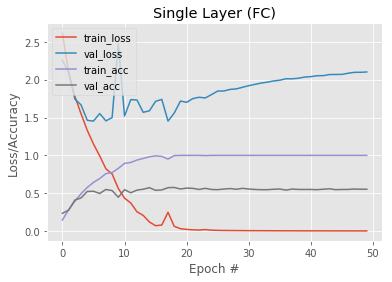

In [6]:
title = 'Single Layer (FC)'
sp_model_fc = cnn.build_cnn(
    height=128, width=128, depth=3, classes=17, conv_cnt=1, conv_layers=1,
    filters=[32], k_size=(3, 3), fc=True, fc_layers=1,
    neuron_cnt=[256])

cnn.run_compile_fit_evaluate(
    sp_model_fc, train_x, train_y, val_x, val_y, n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, plot_chart=True, chart_title=title)

### Three layer CNN with decreasing FC neuron count
32, 64, 128 filters respectively (each layer has three convolution layers and a pooling layer), with a flatten layer and three fully-connected (fc) layers with 256, 128, 64 ReLu neurons respectively before softmax classifier.

> Indented block



Train on 1020 samples, validate on 340 samples
Epoch 1/50
1020/1020 [==============================] - 4s 4ms/sample - loss: 2.8328 - acc: 0.0745 - val_loss: 2.8319 - val_acc: 0.0676
Epoch 2/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.8293 - acc: 0.0716 - val_loss: 2.8272 - val_acc: 0.0735
Epoch 3/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.8181 - acc: 0.0735 - val_loss: 2.8058 - val_acc: 0.0735
Epoch 4/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.7459 - acc: 0.0971 - val_loss: 2.6039 - val_acc: 0.1176
Epoch 5/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.5437 - acc: 0.1725 - val_loss: 2.4017 - val_acc: 0.2176
Epoch 6/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.3064 - acc: 0.2176 - val_loss: 2.2163 - val_acc: 0.2176
Epoch 7/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.1865 - acc: 0.2706 - val_loss: 2.2371 - val_acc: 0.2353
E

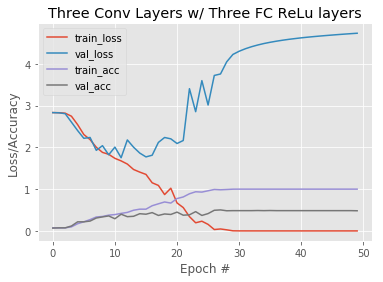

In [7]:
title = 'Three Conv Layers w/ Three FC ReLu layers'
sp_model_3conv = cnn.build_cnn(
    height=128, width=128, depth=3, classes=17, conv_cnt=3, conv_layers=3,
    filters=[32, 64, 128], k_size=(3, 3), fc=True, fc_layers=3,
    neuron_cnt=[256, 128, 64])

cnn.run_compile_fit_evaluate(
    sp_model_3conv, train_x, train_y, val_x, val_y, n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, plot_chart=True, chart_title=title)

### Three layer CNN with fixed FC neuron count and dropout regularisation
Three Layer CNN using 32, 62, 128 filters respectively (each layer has three convolution layers and a pooling layer), with a flatten layer and three FC layers with fixed count of ReLu neurons and dropout regularization respectively before softmax classifier


Train on 1020 samples, validate on 340 samples
Epoch 1/50
1020/1020 [==============================] - 4s 4ms/sample - loss: 2.8336 - acc: 0.0667 - val_loss: 2.8336 - val_acc: 0.0441
Epoch 2/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.8331 - acc: 0.0647 - val_loss: 2.8339 - val_acc: 0.0441
Epoch 3/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.8330 - acc: 0.0559 - val_loss: 2.8340 - val_acc: 0.0441
Epoch 4/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.8327 - acc: 0.0588 - val_loss: 2.8345 - val_acc: 0.0441
Epoch 5/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.8320 - acc: 0.0667 - val_loss: 2.8342 - val_acc: 0.0441
Epoch 6/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.8313 - acc: 0.0657 - val_loss: 2.8339 - val_acc: 0.0588
Epoch 7/50
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.8308 - acc: 0.0716 - val_loss: 2.8328 - val_acc: 0.0529
E

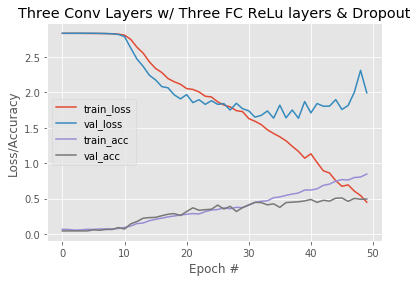

In [8]:
title = 'Three Conv Layers w/ Three FC ReLu layers & Dropout'
sp_model_3conv_drop = cnn.build_cnn(
    height=128, width=128, depth=3, classes=17, conv_cnt=3, conv_layers=3,
    filters=[32, 62, 128], k_size=(3, 3), fc=True, fc_layers=3,
    neuron_cnt=[256, 256, 256], dropout_rate=0.3)

cnn.run_compile_fit_evaluate(
    sp_model_3conv_drop, train_x, train_y, val_x, val_y, n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, plot_chart=True, chart_title=title)

# Part 2 - Augment the training data


### Baseline - Single conv layer w/ singel FC ReLu layer (Augmented)

Epoch 1/50
64/64 [==============================] - 3s 52ms/step - loss: 2.7152 - acc: 0.1284 - val_loss: 2.4932 - val_acc: 0.1882
Epoch 2/50
64/64 [==============================] - 4s 55ms/step - loss: 2.3335 - acc: 0.2294 - val_loss: 2.1707 - val_acc: 0.3265
Epoch 3/50
64/64 [==============================] - 4s 57ms/step - loss: 2.1217 - acc: 0.2824 - val_loss: 2.0971 - val_acc: 0.2324
Epoch 4/50
64/64 [==============================] - 4s 56ms/step - loss: 2.0091 - acc: 0.3186 - val_loss: 1.9281 - val_acc: 0.3647
Epoch 5/50
64/64 [==============================] - 4s 65ms/step - loss: 1.8882 - acc: 0.3539 - val_loss: 1.6962 - val_acc: 0.4000
Epoch 6/50
64/64 [==============================] - 4s 66ms/step - loss: 1.8322 - acc: 0.3686 - val_loss: 1.6603 - val_acc: 0.4441
Epoch 7/50
64/64 [==============================] - 4s 60ms/step - loss: 1.7636 - acc: 0.4039 - val_loss: 1.6629 - val_acc: 0.4529
Epoch 8/50
64/64 [==============================] - 4s 57ms/step - loss: 1.6860 - a

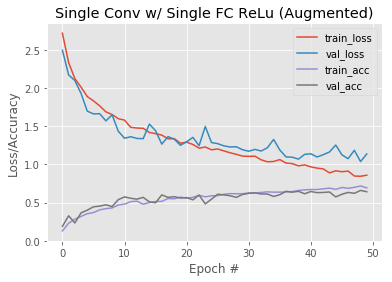

In [9]:
title = 'Single Conv w/ Single FC ReLu (Augmented)'
train_gen_baseline = cnn.augment_training_data(
    train_x, train_y, 16, width_shift=0.1, height_shift=0.1, shear=0.2,
    zoom=0.3, rotation=20, v_flip=True)

aug_model_base = cnn.build_cnn(
    height=128, width=128, depth=3, classes=17, conv_cnt=1, conv_layers=1,
    filters=[32], k_size=(3, 3), fc=True, fc_layers=1, neuron_cnt=[256])

cnn.run_compile_fit_evaluate(
    aug_model_base, train_x, train_y, val_x, val_y, n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, augmented=True, aug_generator=train_gen_baseline,
    plot_chart=True, chart_title=title)

### Increase Variant: Increase image data generator values, add horizontal flip

Epoch 1/50
64/64 [==============================] - 4s 64ms/step - loss: 2.8430 - acc: 0.1000 - val_loss: 2.7709 - val_acc: 0.1324
Epoch 2/50
64/64 [==============================] - 4s 56ms/step - loss: 2.6825 - acc: 0.1324 - val_loss: 2.5139 - val_acc: 0.1294
Epoch 3/50
64/64 [==============================] - 4s 59ms/step - loss: 2.5241 - acc: 0.1618 - val_loss: 2.4191 - val_acc: 0.1765
Epoch 4/50
64/64 [==============================] - 4s 56ms/step - loss: 2.4155 - acc: 0.1843 - val_loss: 2.2058 - val_acc: 0.2559
Epoch 5/50
64/64 [==============================] - 4s 57ms/step - loss: 2.3173 - acc: 0.1961 - val_loss: 2.1561 - val_acc: 0.2412
Epoch 6/50
64/64 [==============================] - 4s 57ms/step - loss: 2.2508 - acc: 0.2490 - val_loss: 2.0543 - val_acc: 0.3059
Epoch 7/50
64/64 [==============================] - 4s 58ms/step - loss: 2.1844 - acc: 0.2627 - val_loss: 2.0741 - val_acc: 0.2853
Epoch 8/50
64/64 [==============================] - 4s 57ms/step - loss: 2.1646 - a

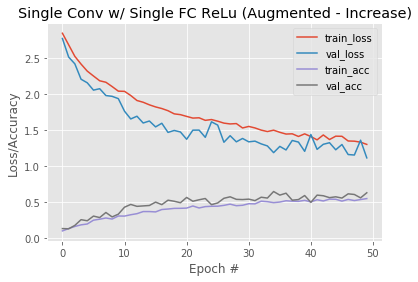

In [10]:
title = 'Single Conv w/ Single FC ReLu (Augmented - Increase)'
train_gen_increase = cnn.augment_training_data(
    train_x, train_y, 16, width_shift=0.3, height_shift=0.3, shear=0.3,
    zoom=0.5, rotation=45, v_flip=True, h_flip=True)

aug_model_inc = cnn.build_cnn(
    height=128, width=128, depth=3, classes=17, conv_cnt=1, conv_layers=1,
    filters=[32], k_size=(3, 3), fc=True, fc_layers=1, neuron_cnt=[256])

cnn.run_compile_fit_evaluate(
    aug_model_inc, train_x, train_y, val_x, val_y, n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, augmented=True, aug_generator=train_gen_increase,
    plot_chart=True, chart_title=title)

### Decrease Variant: Decrease image data generator values, add horizontal flip

Epoch 1/50
64/64 [==============================] - 3s 53ms/step - loss: 2.6184 - acc: 0.1490 - val_loss: 2.2710 - val_acc: 0.2618
Epoch 2/50
64/64 [==============================] - 3s 53ms/step - loss: 2.1823 - acc: 0.2569 - val_loss: 1.9988 - val_acc: 0.3147
Epoch 3/50
64/64 [==============================] - 4s 55ms/step - loss: 1.9923 - acc: 0.3127 - val_loss: 1.8640 - val_acc: 0.3559
Epoch 4/50
64/64 [==============================] - 4s 56ms/step - loss: 1.8672 - acc: 0.3716 - val_loss: 1.7550 - val_acc: 0.4353
Epoch 5/50
64/64 [==============================] - 4s 56ms/step - loss: 1.8043 - acc: 0.3833 - val_loss: 1.5772 - val_acc: 0.4912
Epoch 6/50
64/64 [==============================] - 4s 57ms/step - loss: 1.7036 - acc: 0.4029 - val_loss: 1.5425 - val_acc: 0.4912
Epoch 7/50
64/64 [==============================] - 4s 57ms/step - loss: 1.6338 - acc: 0.4294 - val_loss: 1.5656 - val_acc: 0.4676
Epoch 8/50
64/64 [==============================] - 4s 55ms/step - loss: 1.5935 - a

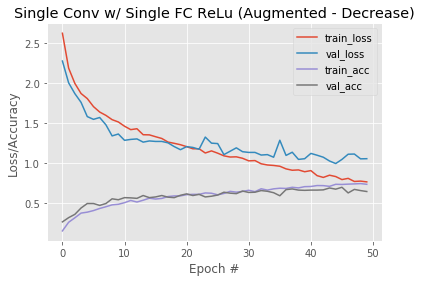

In [11]:
title = 'Single Conv w/ Single FC ReLu (Augmented - Decrease)'
train_gen_dec = cnn.augment_training_data(
    train_x, train_y, 16, width_shift=0.1, height_shift=0.1, shear=0.1,
    zoom=0.1, rotation=10, v_flip=True, h_flip=True)

aug_model_dec = cnn.build_cnn(
    height=128, width=128, depth=3, classes=17, conv_cnt=1, conv_layers=1,
    filters=[32], k_size=(3, 3), fc=True, fc_layers=1, neuron_cnt=[256])

cnn.run_compile_fit_evaluate(
    aug_model_dec, train_x, train_y, val_x, val_y, n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, augmented=True, aug_generator=train_gen_dec,
    plot_chart=True, chart_title=title)

### Combination Variant: Combination of values closer to baseline and add low level dropout

Epoch 1/50
64/64 [==============================] - 3s 54ms/step - loss: 2.7919 - acc: 0.1098 - val_loss: 2.6013 - val_acc: 0.2059
Epoch 2/50
64/64 [==============================] - 4s 56ms/step - loss: 2.5001 - acc: 0.1676 - val_loss: 2.2568 - val_acc: 0.2559
Epoch 3/50
64/64 [==============================] - 4s 55ms/step - loss: 2.3003 - acc: 0.2029 - val_loss: 2.1406 - val_acc: 0.3029
Epoch 4/50
64/64 [==============================] - 4s 57ms/step - loss: 2.1821 - acc: 0.2706 - val_loss: 1.9585 - val_acc: 0.3824
Epoch 5/50
64/64 [==============================] - 4s 58ms/step - loss: 2.0735 - acc: 0.3000 - val_loss: 1.8166 - val_acc: 0.3882
Epoch 6/50
64/64 [==============================] - 4s 65ms/step - loss: 2.0018 - acc: 0.3265 - val_loss: 1.8231 - val_acc: 0.4206
Epoch 7/50
64/64 [==============================] - 4s 66ms/step - loss: 1.9418 - acc: 0.3353 - val_loss: 1.7299 - val_acc: 0.4265
Epoch 8/50
64/64 [==============================] - 4s 58ms/step - loss: 1.8539 - a

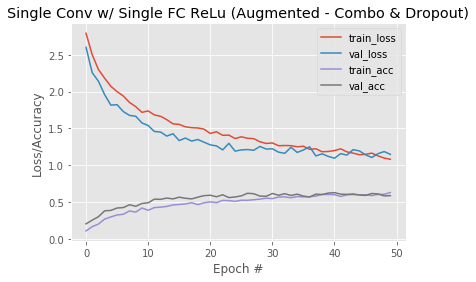

In [12]:
title = 'Single Conv w/ Single FC ReLu (Augmented - Combo & Dropout)'
train_gen_mix = cnn.augment_training_data(
    train_x, train_y, 16, width_shift=0.1, height_shift=0.1, shear=0.2,
    zoom=0.4, rotation=45, v_flip=True, h_flip=True)

aug_model_mix = cnn.build_cnn(
    height=128, width=128, depth=3, classes=17, conv_cnt=1, conv_layers=1,
    filters=[32], k_size=(3, 3), fc=True, fc_layers=1, neuron_cnt=[256],
    dropout_rate=0.1)

cnn.run_compile_fit_evaluate(
    aug_model_mix, train_x, train_y, val_x, val_y, n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, augmented=True, aug_generator=train_gen_mix,
    plot_chart=True, chart_title=title)

# Part 3 - CNN Ensemble

In [13]:
NUM_BASE_LEARNERS = 10
ens_models = list()

for base in range(0, NUM_BASE_LEARNERS):
    train_gen = cnn.augment_training_data(
        train_x, train_y, 16, width_shift=0.1, height_shift=0.1, shear=0.1,
        zoom=0.1, rotation=10, v_flip=True, h_flip=True)

    graph = cnn.build_cnn(
        height=128, width=128, depth=3, classes=17, conv_cnt=1, conv_layers=1,
        filters=[32], k_size=(3, 3), fc=True, fc_layers=1, neuron_cnt=[256],
        dropout_rate=0.1)

    ens_models.append(cnn.run_compile_fit_evaluate(
        graph, train_x, train_y, val_x, val_y, n_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE, augmented=True, aug_generator=train_gen,
        return_model=True))

ens_val_acc = cnn.ensemble_predict(ens_models, val_x, val_y,
                                   batch_size=BATCH_SIZE)

print("Ensemble Validation Accuracy: {}".format(ens_val_acc))

Epoch 1/50
64/64 [==============================] - 3s 55ms/step - loss: 2.6957 - acc: 0.1373 - val_loss: 2.4471 - val_acc: 0.1912
Epoch 2/50
64/64 [==============================] - 4s 55ms/step - loss: 2.3477 - acc: 0.1980 - val_loss: 2.1709 - val_acc: 0.2353
Epoch 3/50
64/64 [==============================] - 4s 57ms/step - loss: 2.1800 - acc: 0.2578 - val_loss: 1.9976 - val_acc: 0.3500
Epoch 4/50
64/64 [==============================] - 4s 67ms/step - loss: 2.0246 - acc: 0.3098 - val_loss: 1.9043 - val_acc: 0.3912
Epoch 5/50
64/64 [==============================] - 3s 54ms/step - loss: 1.9452 - acc: 0.3196 - val_loss: 1.8012 - val_acc: 0.4088
Epoch 6/50
64/64 [==============================] - 4s 55ms/step - loss: 1.8783 - acc: 0.3510 - val_loss: 1.7483 - val_acc: 0.3971
Epoch 7/50
64/64 [==============================] - 4s 55ms/step - loss: 1.7973 - acc: 0.3735 - val_loss: 1.6381 - val_acc: 0.4588
Epoch 8/50
64/64 [==============================] - 4s 55ms/step - loss: 1.6891 - a